/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


{'axi_dma_0': {'phys_addr': 1077936128, 'addr_range': 65536, 'type': 'xilinx.com:ip:axi_dma:7.1', 'state': None, 'interrupts': {}, 'gpio': {}, 'fullpath': 'axi_dma_0', 'mem_id': 'SEG_axi_dma_0_Reg', 'driver': <class 'pynq.lib.dma.DMA'>}}


/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


Number of samples:  2000000


<IPython.core.display.Javascript object>


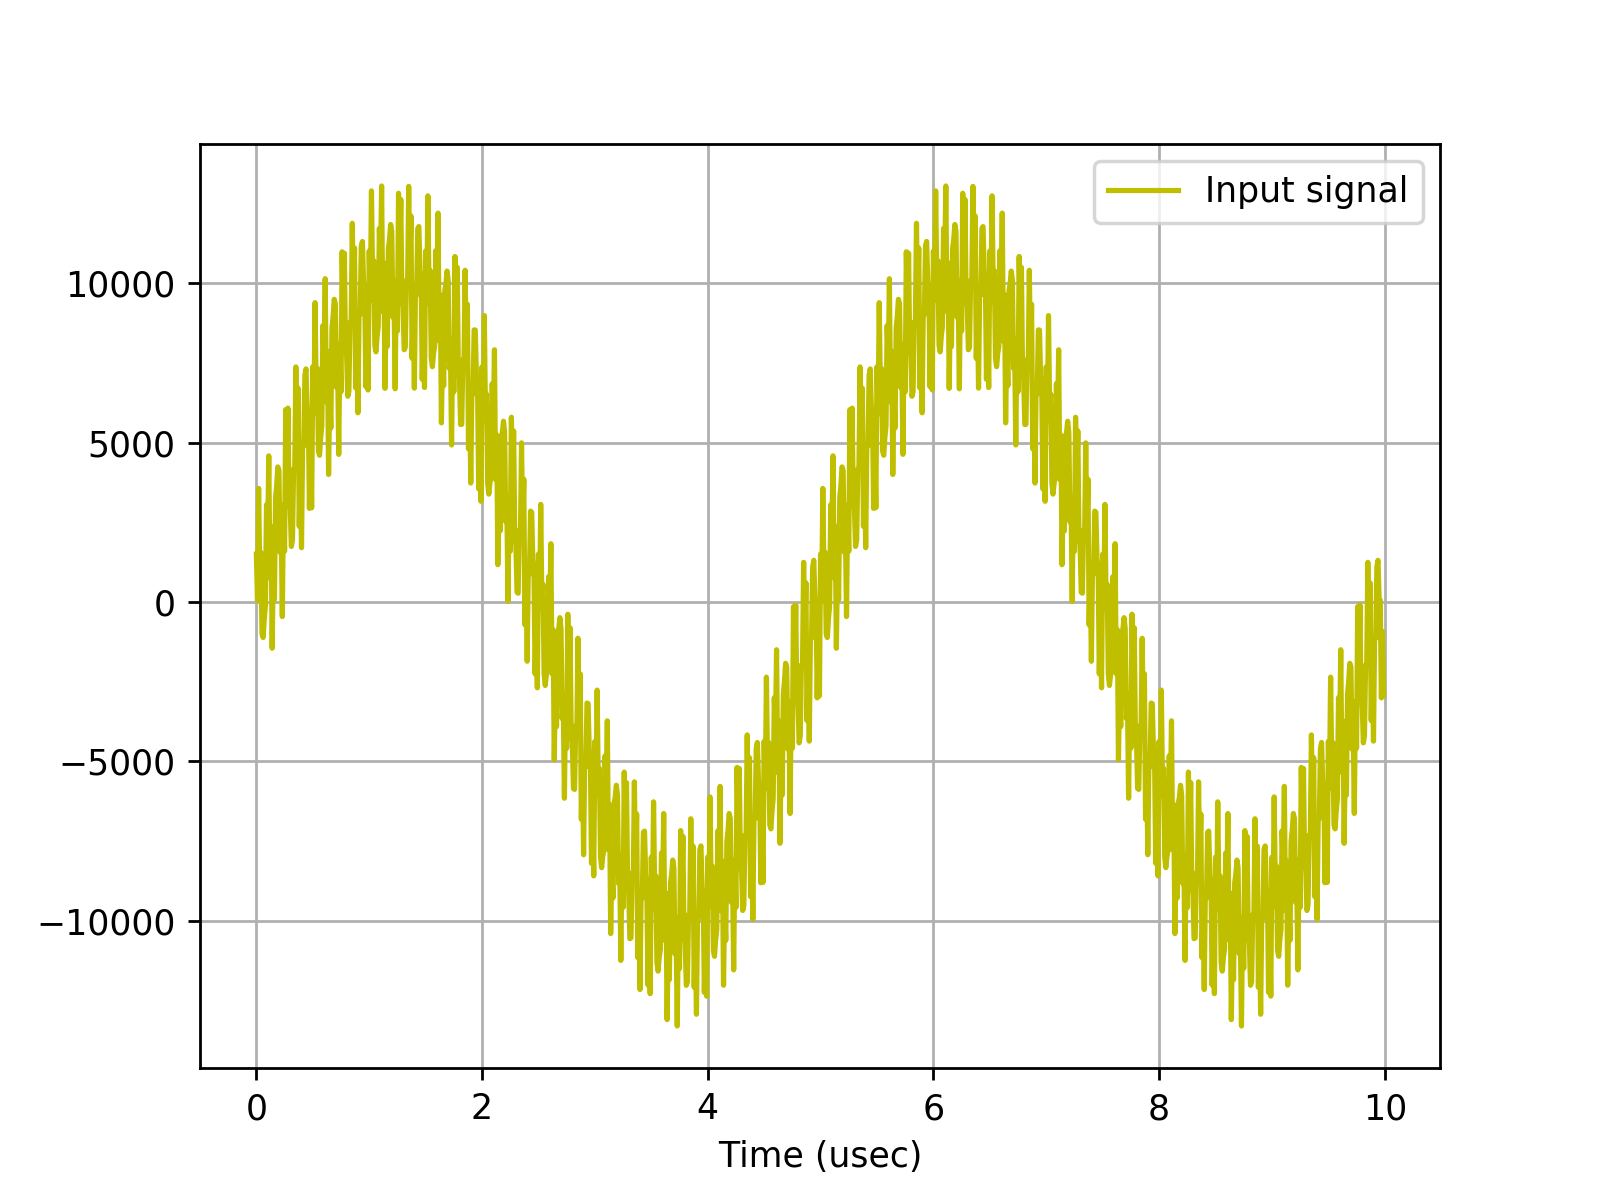

In [1]:
from pynq import Overlay
import pynq.lib.dma

%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='Module output')
    plt.legend()
    
#overlay = Overlay('/home/xilinx/pynq/overlays/custom_axis/custom_axis.bit') #./dmatest2.bit
overlay = Overlay('/home/xilinx/jupyter_notebooks/custom_axis/custom_axis.bit')
print(overlay.ip_dict)
dma = overlay.axi_dma_0


import numpy as np

# Total time
T = 0.02
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ',len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,1000)

Software execution time:  0.11007833480834961


<IPython.core.display.Javascript object>


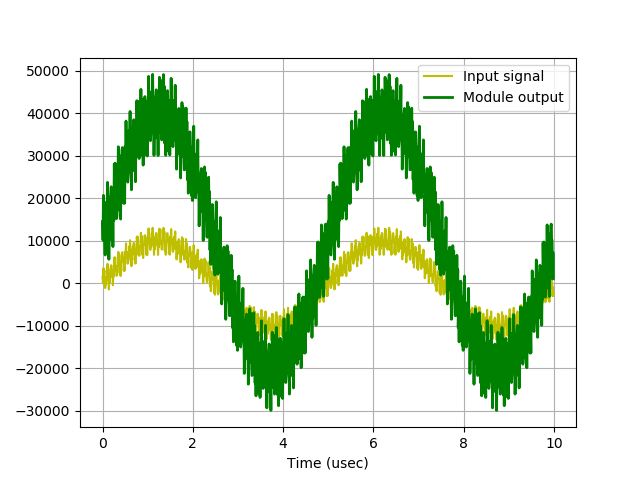

Hardware execution time:  0.021966934204101562
Hardware acceleration factor:  5.011092298341582


<IPython.core.display.Javascript object>


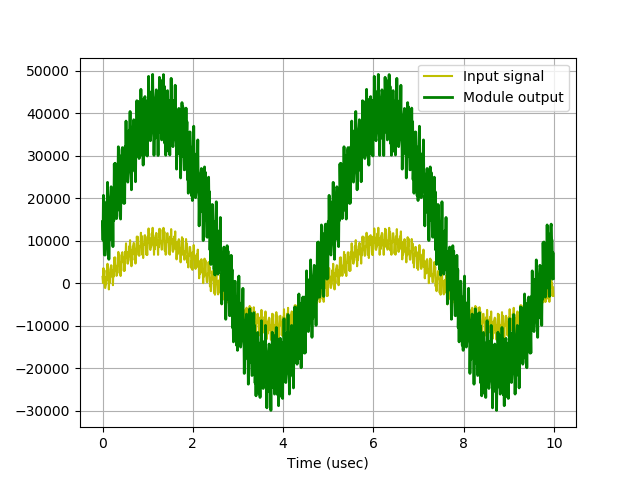

In [2]:
import time
start_time = time.time()
sw_fir_output = 3*samples+10000
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software execution time: ',sw_exec_time)

# Plot the result to notebook
plot_to_notebook(t,samples,1000,out_signal=sw_fir_output)
from pynq import Xlnk
import numpy as np

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware execution time: ',hw_exec_time)
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)
# Plot to the notebook
plot_to_notebook(t,samples,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()